## Analysis of the trajectories of Tropical Atlantic surface drifters deployed during PE-455

*Author: [Erik van Sebille](https://www.uu.nl/staff/EvanSebille)*

*Collaborators: [Erik Zettler](https://www.nioz.nl/en/about/organisation/staff/erik-zettler), [Linda Amaral_Zettler](https://www.nioz.nl/en/about/organisation/staff/linda-amaral-zettler), [Nico Wienders](http://ocean.fsu.edu/~wienders/), [Rick Lumpkin](https://www.aoml.noaa.gov/phod/people/lumpkin/).*

**Summary:** During [RV Pelagia Sargassum Cruise PE-455](https://www.nioz.nl/en/blog/niozatsea-rv-pelagia-sargassum-cruise-pe-455), we deployed a total of 20 custom-built Stokes drifters and 18 drogued SVP drifters as part of the NOAA [Global Drifter Program](https://www.aoml.noaa.gov/phod/gdp/). Most of these drifters were deployed in pairs-of-pairs, where 2 Stokes and 2 SVP drifters were deployed at the same time across the Tropical Atlantic Ocean. In this interactive notebook, we will analyze these trajectories. We will particularly focus on the difference in pathways and dispersion between the undrogued Stokes drifters and the drogued SVP drifters, and also compare the trajectories to virtual trajectories simulated using CMEMS ocean flow fields.

This Jupyter Python notebook contains all the code to recreate all the figures, and allows (in interactive mode) to explore the data further. However, it is also accessible without 'speaking' Python; in that case just read the text and look at the figures.

We start by importing the relevant libraries

In [1]:
%pylab inline
from collections import defaultdict
import datetime
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import cartopy
import geopy.distance

Populating the interactive namespace from numpy and matplotlib


We can now create a specific class to store the drifter information, and load in all the different drifter data sets. These are:
1. The Stokes drifters deployed during PE-445
2. The SVP drifters deployed during PE-445

In [2]:
class Drifters(object):
    def __init__(self, fname, name, color):
        data = np.load(fname, allow_pickle=True)
        self.lons = data['lons'].item()
        self.lats = data['lats'].item()
        if not isinstance(self.lons[0], np.ndarray):
            for d in self.lons:
                self.lons[d] = np.array(self.lons[d])
                self.lats[d] = np.array(self.lats[d])
        self.dates = data['dates'].item()
        if 'sets' in data:
            self.sets_all = data['sets']
            # One Stokes drifter was deployed on its own; remove that from the list of sets
            self.sets = self.sets_all
            self.sets = np.delete(self.sets_all, 6)
            if not isinstance(self.sets[0], list):
                self.sets = [[d] for d in self.sets]
        if 'launch_lon' in data:
            self.launch_lons = data['launch_lon'].item()
        if 'launch_lat' in data:
            self.launch_lats = data['launch_lat'].item()
        if 'launch_times' in data:
            self.launch_dates = data['launch_times'].item()
        self.name = name
        self.color = color

Stokes = Drifters('spottrajs_200515.npz', 'Paired Stokes drifters', 'r')
SVPs = Drifters('gdptrajs_200508.npz', 'Paired NOAA SVP drifters', 'b')

### Overview of drifter trajectories

Let's plot all these trajectories, with the Stokes drifters in red and the SVP drifters in blue. The black triangles are the release locations of the nine pairs-of-pairs. Note that, because the GDP database is only updated until 1 October 2019, we don't have more data yet for these SVP drifters

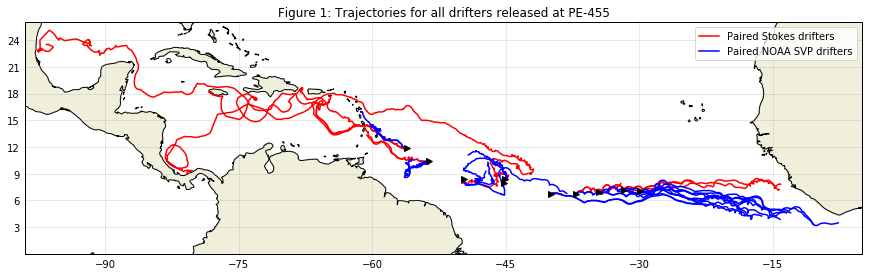

In [3]:
pylab.rcParams['figure.figsize'] = (15, 5)

projection = cartopy.crs.PlateCarree()
fig, ax = plt.subplots(1, 1, subplot_kw={'projection': projection})
ax.coastlines(resolution='50m')
ax.add_feature(cartopy.feature.LAND)

for drifters in [Stokes, SVPs]:
    for i, d in enumerate(drifters.lons):
        label = drifters.name if i == 0 else '_'
        ax.plot(drifters.lons[d], drifters.lats[d], drifters.color, label=label)

ax.plot([Stokes.launch_lons[s[0]] for s in Stokes.sets_all],
        [Stokes.launch_lats[s[0]] for s in Stokes.sets_all], 'k>', zorder=10)

gl = ax.gridlines(crs=cartopy.crs.PlateCarree(), draw_labels=True, linewidth=0.5,
                  color='gray', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.ylabels_right = False
ax.set_extent([-99, -5, 0, 26], crs=cartopy.crs.PlateCarree())
ax.legend()
plt.title('Figure 1: Trajectories for all drifters released at PE-455')
savefig('mapped_trajectories.pdf')
plt.show()

What's clear from the figure above is that the drifters released east of ~42W move eastward, while drifters released west of that move westward into the Caribbean. However, this difference in transport direction might also be related to seasonal changes in currents, as the pair-of-pair deployments were done from east to west.

An alternative way to visualize the trajectories is in an animation, showing drifter pathways every day. In this case, we also add a third data set:
3. All other SVP drifters in the GDP dataset in the region between July-October 2019

In [4]:
SVP_all = Drifters('gdptrajsAllTrAtl_200511.npz', 'Other NOAA SVP drifters', '0.75')

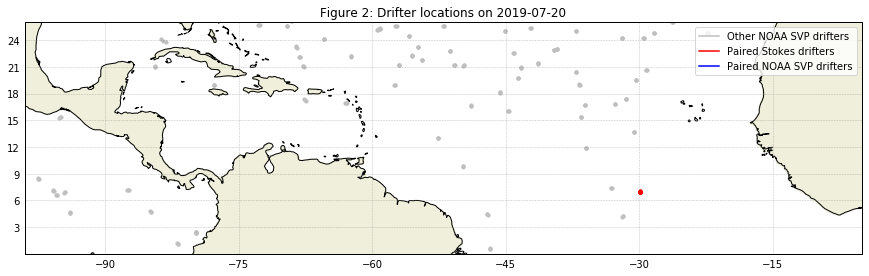

In [5]:
pylab.rcParams['figure.figsize'] = (15, 5)


projection = cartopy.crs.PlateCarree()
fig, ax = plt.subplots(1, 1, subplot_kw={'projection': projection})
ax.coastlines(resolution='50m')
ax.add_feature(cartopy.feature.LAND)

plottimes = [datetime.datetime(2019, 7, 20) + datetime.timedelta(days=d) for d in range(70)]

scat = {}
for drifters in [SVP_all, Stokes, SVPs]:
    ax.plot(-100, -100, color=drifters.color, label=drifters.name)
    for d in drifters.lons:
        scat[d] = ax.scatter(-100, -100, s=10, color=drifters.color)
ttl = ax.set_title('Figure 2: Drifter locations on ' + plottimes[0].strftime("%Y-%m-%d"))

gl = ax.gridlines(crs=cartopy.crs.PlateCarree(), draw_labels=True, linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.ylabels_right = False
ax.set_extent([-99, -5, 0, 26], crs=cartopy.crs.PlateCarree())
ax.legend(loc='upper right')

frames = np.arange(0, len(plottimes)-1)
def animate(t):
    for drifters in [SVP_all, Stokes, SVPs]:
        for d in drifters.lons:
            I = [i for i, d2 in enumerate(drifters.dates[d]) if plottimes[t] < d2.replace(tzinfo=None) < plottimes[t+1]]
            scat[d].set_offsets(np.vstack((drifters.lons[d][I], drifters.lats[d][I])).transpose())
    ttl.set_text('Figure 2: Drifter locations on ' + plottimes[t].strftime("%Y-%m-%d"))
    return scat
anim = animation.FuncAnimation(fig, animate, frames=frames, interval=100, blit=False)
anim.save('sargassum_drifters.gif', writer='imagemagick', fps=10)

The code above produced an animated gif. However, because this will not play automatically within the notebook, we execute the animated gif with `![SegmentLocal](sargassum_drifters.gif "segment")` below

![SegmentLocal](sargassum_drifters.gif "segment")

### Analyzing drifter pair dispersion

Now let's have a look at the dispersion between each pair of drifters, focusing on the first five days after deployment

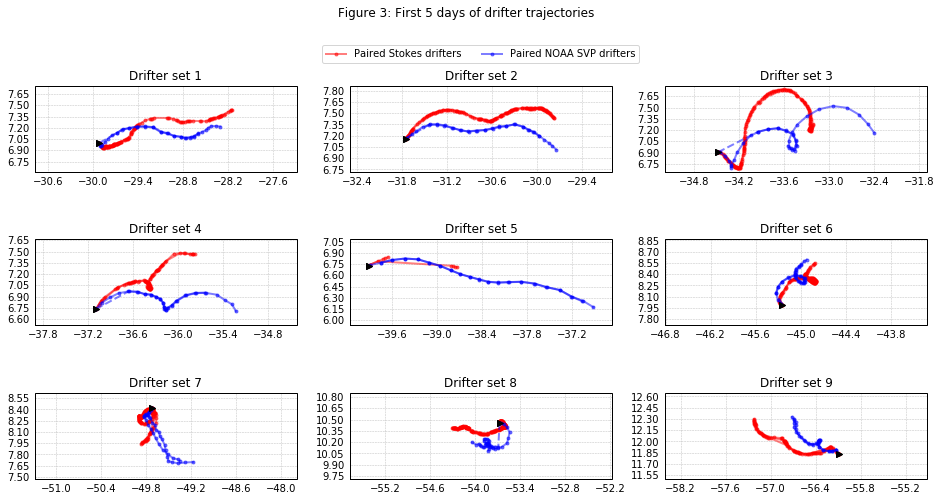

In [6]:
pylab.rcParams['figure.figsize'] = (16, 8)

projection = cartopy.crs.PlateCarree()
fig, ax = plt.subplots(3, 3, subplot_kw={'projection': projection})
ax = ax.ravel()

maxlen = datetime.timedelta(days=5)
width = 3.5
height = 1.15

for i, ai in enumerate(ax):
    ai.coastlines(resolution='50m')
    ai.add_feature(cartopy.feature.LAND)
    for drifters in [Stokes, SVPs]:
        for j, d in enumerate(drifters.sets[i]):
            I = [i for i, d2 in enumerate(drifters.dates[d]) if d2 < drifters.dates[d][0]+maxlen]
            label = drifters.name if j == 0 and i == 1 else '_'
            marker = '.' if 'Paired' in drifters.name else None
            ai.plot(drifters.lons[d][I], drifters.lats[d][I], drifters.color,
                    alpha=0.5, linewidth=2, marker=marker, label=label)
            if drifters.dates[d][0].replace(tzinfo=None) > drifters.launch_dates[d].replace(tzinfo=None) + datetime.timedelta(hours=12):
                ai.plot([drifters.launch_lons[d], drifters.lons[d][0]], [drifters.launch_lats[d], drifters.lats[d][0]],
                        drifters.color, alpha=0.5, linewidth=2, linestyle='--')
        ai.plot(Stokes.launch_lons[Stokes.sets[i][0]], Stokes.launch_lats[Stokes.sets[i][0]], 'k>')

    gl = ai.gridlines(crs=cartopy.crs.PlateCarree(), draw_labels=True,
                      linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
    gl.xlabels_top = False
    gl.ylabels_right = False
    if i == 1:
        ai.legend(bbox_to_anchor=(0.5, 1.2), loc='lower center', ncol=2)
    xl, yl = ai.get_xlim(), ai.get_ylim()
    ai.set_xlim(np.mean(xl)-width/2, np.mean(xl)+width/2)
    ai.set_ylim(np.mean(yl)-height/2, np.mean(yl)+height/2)
    ai.set_title('Drifter set %s' % str(i+1))

fig.suptitle('Figure 3: First %d days of drifter trajectories' % maxlen.days)
savefig('dispersion_first%ddays.pdf' % maxlen.days)
plt.show()

What you see above is that for most of the pairs, the pathways from their release are fairly similar. Also not that for pair 5 (center image), we have only a few location fixes for the Stokes drifters.

Using the pairs-of-pairs trajectories, we can do an analysis of the dispersion in the first 20 days of the drifter releases, following the analysis of SVP pair dispersion in the Southern Ocean from [Van Sebille et al 2015](https://agupubs.onlinelibrary.wiley.com/doi/full/10.1002/2015JC010972).

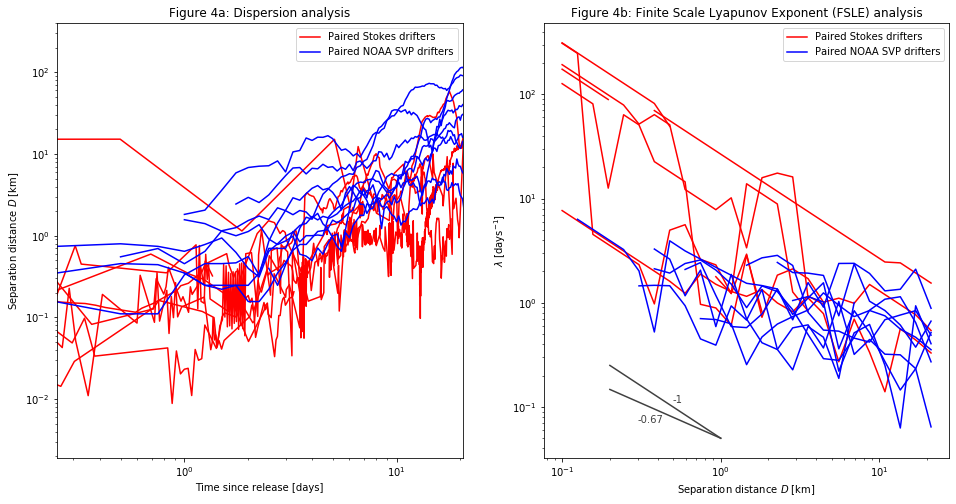

In [7]:
pylab.rcParams['figure.figsize'] = (16, 8)
fig, ax = plt.subplots(1, 2)

maxlen = datetime.timedelta(days=30)
for drifters in [Stokes, SVPs]:
    drifters.datediff = defaultdict(list)
    drifters.distdiff = defaultdict(list)
    for i, s in enumerate(drifters.sets):
        for I0, date0 in enumerate(drifters.dates[s[0]]):
            if date0 <= drifters.dates[s[0]][0] + maxlen:
                ddiff = [abs(date1 - date0) for date1 in drifters.dates[s[1]]]
                I1 = np.argmin(ddiff)
                if ddiff[I1] < datetime.timedelta(minutes=30):
                    drifters.datediff[i].append((date0-drifters.dates[s[0]][0]).total_seconds()/86400.)
                    drifters.distdiff[i].append(geopy.distance.distance((drifters.lats[s[1]][I1], drifters.lons[s[1]][I1]),
                                                                        (drifters.lats[s[0]][I0], drifters.lons[s[0]][I0])).km)
        label = drifters.name if i == 0 else '_'
        ax[0].loglog(drifters.datediff[i], drifters.distdiff[i], drifters.color, label=label)

ax[0].set_xlim([6./24, datetime.timedelta(days=20).total_seconds()/84400])
ax[0].set_xlabel('Time since release [days]')
ax[0].set_ylabel('Separation distance $D$ [km]')
ax[0].set_title('Figure 4a: Dispersion analysis')
ax[0].legend()


delta = [10**e for e in np.arange(-1, np.log10(30), np.log10(1.25))]
for drifters in [Stokes, SVPs]:
    lamdastd = np.nan*np.zeros(len(delta)-1)
    for i in drifters.distdiff:
        lamda = np.nan*np.zeros(len(delta)-1)
        for t in range(len(lamda)):
            alpha = delta[t+1] / delta[t]
            i2 = np.argwhere(drifters.distdiff[i] > delta[t+1])
            if len(i2) == 0:
                continue
            i2 = i2[0][0]
            i1 = np.argwhere(drifters.distdiff[i][:i2] <= delta[t])
            if len(i1) == 0:
                continue
            i1 = i1[-1][0]
            factor = (drifters.distdiff[i][i2] - drifters.distdiff[i][i1]) / (delta[t+1] - delta[t])
            deltat = (drifters.datediff[i][i2] - drifters.datediff[i][i1]) / factor
            lamda[t] = np.log(alpha) / deltat
        label = drifters.name if i == 0 else '_'
        ax[1].loglog(delta[:-1], lamda, color=drifters.color, label=label)

ax[1].set_xlabel('Separation distance $D$ [km]')
ax[1].set_ylabel('${\lambda}$ [days$^{-1}$]')
plt.yscale('log', nonposy='clip')
ax[1].set_title('Figure 4b: Finite Scale Lyapunov Exponent (FSLE) analysis')
ax[1].legend()

xfit = [0.2, 1]
ax[1].plot(xfit, [0.05*x**(-1) for x in xfit], color='0.25')
plt.text(0.5, 0.11, '-1', color='0.25')
ax[1].plot(xfit, [0.05*x**(-0.67) for x in xfit], color='0.25')
plt.text(0.3, 0.07, '-0.67', color='0.25')

savefig('dispersion_fsle_analysis.pdf')
plt.show()

In the Figure above, the left panel shows for the distance between the two drifters in each pair, as a function of time on a log-log-scale. What is clear here is that the SVP drifters have in general separated farther than the SVP drifters, after a certain amount of time. Note that, since the SVP drifters from MeteoFrance were programmed to start transmitting the day after their deployment, many of the blue lines in panel a start a few hours to a day after deployment. 

The right panel above shows the Finite Scale Lyapunov Exponent analysis for each pair, which is an estimate of the rate at which the drifters in each pair separate, as a function of their separation. Again, the SVP drifters appear to separate faster than the Stokes drifters, since a larger $\lambda$ means slower separation.

### Comparing to virtual drifters

In this third part of the analysis, we use hydrodynamic data from the [Copernicus Marine Environmental Monitoring Service (CMEMS)](https://resources.marine.copernicus.eu/?option=com_csw&task=results) and then in particular the `GLOBAL_ANALYSIS_FORECAST_PHY_001_024-TDS` run, to explore to what extent the SVP and Stokes trajectories can be explained by the different components of the surface flow.

What's nice about the `GLOBAL_ANALYSIS_FORECAST_PHY_001_024-TDS` run is that it has data for the Eulerian (Navier-Stokes), the wave-driven (Stokes) and tidal components of the surface flow, as well as the total currents.

I have used the script [`cmems_download_script.py`](cmems_download_script.py) (requires changing username and password) to download in total 22GB of surface current data for the period Jul-Oct 2019 from the CMEMS servers using their `motu` client. I then used the [`sargassum_parcels_simulation.ipynb`](sargassum_parcels_simulation.ipynb) notebook to compute virtual particle trajectories in the four sets of velocity fields, using the [OceanParcels.org](http://oceanparcels.org) code. In each simulation, I started one virtual particle at each of the nine release locations and dates, and then computed their pathways for five days.

We can analyze these four different simulations, and compare them with the observed drifters, with the code below

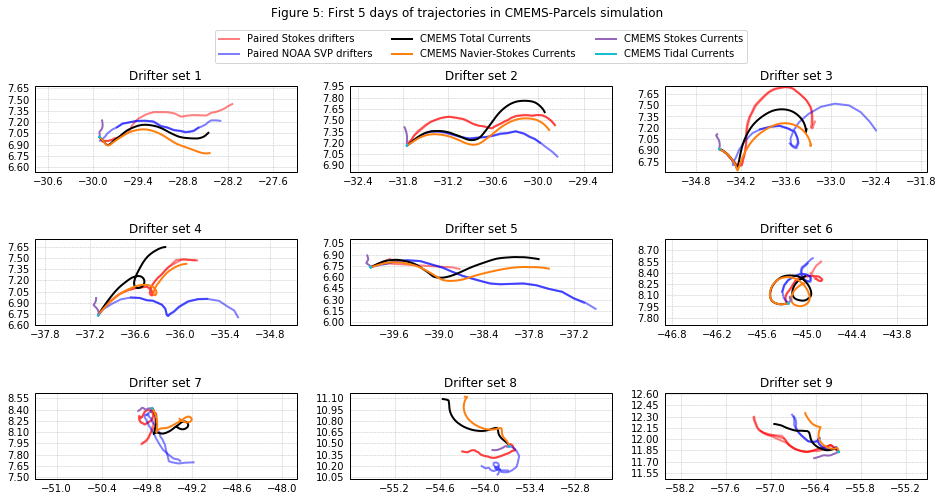

In [8]:
parcels_total = Drifters('parcelstrajs_total.npz', 'CMEMS Total Currents', 'k')
parcels_curr = Drifters('parcelstrajs_curr.npz', 'CMEMS Navier-Stokes Currents', 'C1')
parcels_stokes = Drifters('parcelstrajs_stokes.npz', 'CMEMS Stokes Currents', 'C4')
parcels_tide = Drifters('parcelstrajs_tide.npz', 'CMEMS Tidal Currents', 'C9')

pylab.rcParams['figure.figsize'] = (16, 8)
projection = cartopy.crs.PlateCarree()
fig, ax = plt.subplots(3, 3, subplot_kw={'projection': projection})
ax = ax.ravel()

maxlen = datetime.timedelta(days=5)
width = 3.5
height = 1.15

for i, ai in enumerate(ax):
    ai.coastlines(resolution='50m')
    ai.add_feature(cartopy.feature.LAND)
    for drifters in [Stokes, SVPs, parcels_total, parcels_curr, parcels_stokes, parcels_tide]:
        for j, d in enumerate(drifters.sets[i]):
            label = drifters.name if j == 0 and i == 1 else '_'
            alpha = 0.5 if 'Paired' in drifters.name else 1.0
            I = [i for i, d2 in enumerate(drifters.dates[d]) if d2 < drifters.dates[d][0]+maxlen]
            ai.plot(drifters.lons[d][I], drifters.lats[d][I], drifters.color, linewidth=2, 
                    label=label, alpha=alpha)

    gl = ai.gridlines(crs=cartopy.crs.PlateCarree(), draw_labels=True,
                      linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
    gl.xlabels_top = False
    gl.ylabels_right = False
    if i == 1:
        ai.legend(bbox_to_anchor=(0.5, 1.2), loc='lower center', ncol=3)
    xl, yl = ai.get_xlim(), ai.get_ylim()
    ai.set_xlim(np.mean(xl)-width/2, np.mean(xl)+width/2)
    ai.set_ylim(np.mean(yl)-height/2, np.mean(yl)+height/2)
    ai.set_title('Drifter set %s' % str(i+1))

fig.suptitle('Figure 5: First %d days of trajectories in CMEMS-Parcels simulation' % maxlen.days)
savefig('parcels_first%ddays.pdf' % maxlen.days)
plt.show()

The above panels show the same nine drifter pair-of-pairs again, with the Stokes drifters in red and the SVP drifters in blue. The four simulations are the other colors. In the region, the transport by the modeled Stokes currents (purple) is relatively small, and the transport by the tides (cyan) is almost negligible. 

In general, it appears that the CMEMS surface currents (and especially the total current) better represent the undrogued Stokes drifters than the drogued SVP drifters, as expected. 

### Further steps

It is a petty that the length of the trajectories of the Stokes varies so much. Some Stokes drifters have transmitted for not more than a few days, while others have transmitted for almost a year. The total amount of data, however, is somewhat limited. The question is thus how we can further augment this analysis. 

One easy extra step is to repeat the comparison to virtual drifters for other locations/times along the trajectories, not only the release locations. Together with a more robust quantification of the goodness-of-simulation for the different model velocity fields, this would allow us to tune our models in order to best simulate floating material. 

The question is whether that would be enough for a manuscript. Other ideas very welcome!